In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from qiskit_optimization.applications.vertex_cover import VertexCover

In [2]:
data = pd.read_csv("data/hero-network.csv")

In [6]:
data.loc[80519,:]

hero1    TALISMAN II/ELIZABET
hero2    WILD CHILD/KYLE GIBN
Name: 80519, dtype: object

In [3]:
heroes = {'MEDUSA/MEDUSALITH AM','ARCLIGHT/PHILLIPA SO','WOLVERINE/LOGAN ','SCARLET WITCH/WANDA ',
          'ARAGORN','OVERMIND/GROM','BATTLEAXE/','ION/', 'PINK PEARL/'}
relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 895 to 573288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero1   103 non-null    object
 1   hero2   103 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [4]:
relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns).drop_duplicates(subset=['hero1', 'hero2'])

In [5]:
graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')

In [6]:
adjacency = nx.to_pandas_adjacency(graph, dtype=int)

In [7]:
vertex_cover = VertexCover(adjacency.to_numpy())

In [8]:
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

qp = vertex_cover.to_quadratic_program()

backend = Aer.get_backend("statevector_simulator")

# create the quantum instance
quantum_instance = QuantumInstance(backend)

# specify the solver method
qaoa = QAOA(reps=3, quantum_instance=quantum_instance)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
result = qaoa_optimizer.solve(qp)

print("solution:", vertex_cover.interpret(result))

solution: [0, 1, 3, 5, 6, 7]


C:\Users\ganiy\anaconda3\envs\qiskit\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


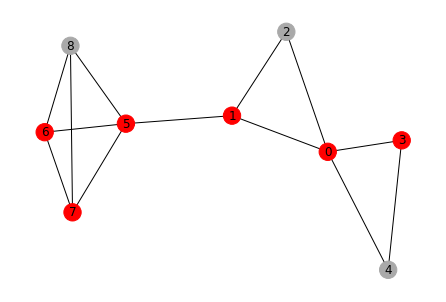

In [9]:
vertex_cover.draw(result)

In [10]:
from typing import Dict, List, Optional, Union

import networkx as nx
import numpy as np
from docplex.mp.model import Model
from qiskit_optimization.algorithms import OptimizationResult
from qiskit_optimization.problems.quadratic_program import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications.graph_optimization_application import GraphOptimizationApplication

In [11]:
class VertexCover(GraphOptimizationApplication):
    """Optimization application for the "vertex cover" problem based on a NetworkX graph."""
    def to_quadratic_program(self) -> QuadraticProgram:
        """Convert a vertex cover instance into a:class:`~qiskit_optimization.problems.QuadraticProgram`
        Returns:
        The :class:`~qiskit_optimization.problems.QuadraticProgram` created
        from the vertex cover instance.
        """
        mdl = Model(name="Vertex cover")
        n = self._graph.number_of_nodes()
        x = {i: mdl.binary_var(name=f"x_{i}") for i in range(n)}
        objective = mdl.sum(x[i] for i in x)
        for w, v in self._graph.edges:
            mdl.add_constraint(x[w] + x[v] >= 1)
        mdl.minimize(objective)
        op = from_docplex_mp(mdl)
        return op
    
    def interpret(self, result: Union[OptimizationResult, np.ndarray]) -> List[int]:
        """Interpret a result as a list of node indices
        Args:
        result : The calculated result of the problem
        Returns: A list of node indices whose corresponding variable is 1
        """
        x = self._result_to_x(result)
        vertex_cover = []
        for i, value in enumerate(x):
            if value:
                vertex_cover.append(i)
        return vertex_cover
    def _draw_result(self, result: Union[OptimizationResult, np.ndarray], pos: Optional[Dict[int, np.ndarray]] = None,) -> None:
        """Draw the result with colors
        Args:
        result : The calculated result for the problem
        pos: The positions of nodes
        """
        x = self._result_to_x(result)
        nx.draw(self._graph, node_color=self._node_colors(x), pos=pos, with_labels=True)

    def _node_colors(self, x: np.ndarray) -> List[str]:
        # Return a list of strings for draw.\
        # Color a node with red when the corresponding variable is 1.
        # Otherwise color it with dark gray.
        return ["r" if x[node[0]] else "darkgrey" for node in self._graph.nodes]

In [12]:
from qiskit_optimization.applications import VertexCover

class WeightedVertexCover(VertexCover):
    """Optimization application for the "weighted vertex cover" problem based on a NetworkX graph."""
    def to_quadratic_program(self) -> QuadraticProgram:
        mdl = Model(name="Weighted Vertex cover")
        n = self._graph.number_of_nodes()
        x = {i: mdl.binary_var(name=f"x_{i}") for i in range(n)}
        nodes = dict(enumerate(self._graph.nodes))
        lnodes = list(self._graph.nodes)
        
        max_weight= max(self._graph.nodes[node]['weight'] for node in lnodes)
        
        for w, v in self._graph.edges:
            self._graph.edges[w, v].setdefault("weight", 1)
            objective = mdl.sum(x[i] * (max_weight-self._graph.nodes[nodes[i]]['weight']) for i in x)
        
        for w, v in self._graph.edges:
            mdl.add_constraint(x[lnodes.index(w)] + x[lnodes.index(v)] >= 1)
            mdl.minimize(objective)
            op = from_docplex_mp(mdl)
        
        return op
    
    def _node_colors(self, x: np.ndarray) -> List[str]:
        nodes = list(dict(enumerate(self._graph.nodes)).items())

        # Return a list of strings for draw.
        # Color a node with red when the corresponding variable is 1.
        # Otherwise color it with dark gray.
        return ["r" if x[node[0]] else "darkgrey" for node in nodes]

In [13]:
count_series1 = data.groupby(['hero1']).size()
count_series2 = data.groupby(['hero2']).size()
appearences = count_series1.add(count_series2, fill_value=0)
for hero in heroes:
    graph.nodes[hero]["weight"] = appearences[hero]

weighted_vertex_cover = WeightedVertexCover(graph)

In [14]:
df = pd.DataFrame(appearences)
df["hero"] = df.index
df.set_index = ""
df[df["hero"] == hero]

,0,hero
PINK PEARL/,147.0,PINK PEARL/


In [15]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# loading the problem
qp = weighted_vertex_cover.to_quadratic_program()

# specifying the backend and the quantum instance
backend = Aer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)

qaoa = QAOA(reps=2, quantum_instance=quantum_instance)

# create minimum eigen optimizer based on qaoa
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve quadratic program
result = qaoa_optimizer.solve(qp)
print("solution:", weighted_vertex_cover.interpret(result))
print("time:", result.min_eigen_solver_result.optimizer_time)

solution: [0, 1, 3, 5, 7, 8]
time: 41.637839794158936


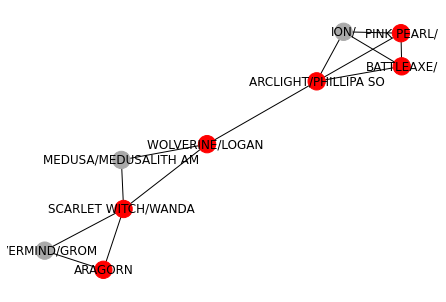

In [16]:
weighted_vertex_cover.draw(result)